In [1]:
import sys
!{sys.executable} -m pip install python-dotenv

In [52]:
import sys
!{sys.executable} -m pip install xagg

In [2]:
from dotenv import dotenv_values

config = dotenv_values("../.env")

In [53]:
%matplotlib inline
import matplotlib.pyplot as plt
# import matplotlib
# import cartopy.crs as ccrs
# from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
# import holoviews as hv
# hv.extension("matplotlib")
# from holoviews.plotting.mpl import MPLRenderer
import xarray as xr
import xagg as xa
import numpy as np
import s3fs
import fsspec
import hvplot.xarray
import hvplot.pandas
import hvplot.dask

import pandas as pd
import geopandas as gpd

In [4]:
import dask
from dask.distributed import Client
import dask_gateway

gateway = dask_gateway.Gateway()
cluster = gateway.new_cluster()

/srv/conda/envs/notebook/lib/python3.9/site-packages/dask_gateway/client.py:21: FutureWarning: format_bytes is deprecated and will be removed in a future release. Please use dask.utils.format_bytes instead.
  from distributed.utils import LoopRunner, format_bytes


In [5]:
cluster.scale(6)
client = Client(cluster)
cluster

In [6]:
sfs = s3fs.S3FileSystem(
    anon=False,
    key="gregor",
    secret=config["fue_s3_key"],
    client_kwargs={
        "endpoint_url": "http://s3.fuecluster.hakom.at:9000",
    }
)
mapper = sfs.get_mapper("/energy-market-visual-exploration/era5_hourly_europe_2011_2021.zarr")

In [7]:
era5_europe = xr.open_zarr(mapper)
era5_europe

<xarray.Dataset>
Dimensions:                      (valid_time_end_utc: 96432, lat: 183, lon: 258)
Coordinates:
  * lat                          (lat) float32 80.5 80.25 80.0 ... 35.25 35.0
  * lon                          (lon) float32 -24.25 -24.0 ... 39.75 40.0
  * valid_time_end_utc           (valid_time_end_utc) datetime64[ns] 2011-01-...
Data variables:
    air_temperature_at_2_metres  (valid_time_end_utc, lat, lon) float32 dask.array<chunksize=(720, 20, 20), meta=np.ndarray>
    eastward_wind_at_10_metres   (valid_time_end_utc, lat, lon) float32 dask.array<chunksize=(720, 20, 20), meta=np.ndarray>
    northward_wind_at_10_metres  (valid_time_end_utc, lat, lon) float32 dask.array<chunksize=(720, 20, 20), meta=np.ndarray>
Attributes:
    institution:  ECMWF
    source:       Reanalysis
    tilte:        ERA5 forecasts

In [8]:
windspeed = (era5_europe["eastward_wind_at_10_metres"] ** 2 + era5_europe["northward_wind_at_10_metres"] ** 2) ** 0.5
windspeed.attrs["units"] = era5_europe["eastward_wind_at_10_metres"].attrs["units"]
era5_europe["windspeed"] = windspeed
era5_europe = era5_europe.drop(["eastward_wind_at_10_metres", "northward_wind_at_10_metres"])
era5_europe

<xarray.Dataset>
Dimensions:                      (valid_time_end_utc: 96432, lat: 183, lon: 258)
Coordinates:
  * lat                          (lat) float32 80.5 80.25 80.0 ... 35.25 35.0
  * lon                          (lon) float32 -24.25 -24.0 ... 39.75 40.0
  * valid_time_end_utc           (valid_time_end_utc) datetime64[ns] 2011-01-...
Data variables:
    air_temperature_at_2_metres  (valid_time_end_utc, lat, lon) float32 dask.array<chunksize=(720, 20, 20), meta=np.ndarray>
    eastward_wind_at_10_metres   (valid_time_end_utc, lat, lon) float32 dask.array<chunksize=(720, 20, 20), meta=np.ndarray>
    northward_wind_at_10_metres  (valid_time_end_utc, lat, lon) float32 dask.array<chunksize=(720, 20, 20), meta=np.ndarray>
    windspeed                    (valid_time_end_utc, lat, lon) float32 dask.array<chunksize=(720, 20, 20), meta=np.ndarray>
Attributes:
    institution:  ECMWF
    source:       Reanalysis
    tilte:        ERA5 forecasts

In [12]:
era5_europe["windspeed"].sel({"valid_time_end_utc": "2019-01-01T00:00:00.000000000"}).hvplot.contour(levels=20, coastline=True)

/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/crs.py

:Overlay
   .Contours.I  :Contours   [lon,lat]   (windspeed)
   .Coastline.I :Feature   [Longitude,Latitude]

In [10]:
# if we want to render a mp4 we can do it like that - just be aware that this will take a long time

# windspeed_daily = era5_europe["windspeed"].resample(valid_time_end_utc="D").mean()
# windspeed_daily

# ds = hv.Dataset(windspeed_daily.sel({"valid_time_end_utc": slice("2019-01-01", "2019-02-01")}))
# images = ds.to(hv.Image, ["lon", "lat"]).options(fig_inches=(10, 5), colorbar=True, cmap="viridis")

# renderer = MPLRenderer.instance(holomap="mp4")
# with open("../figs/wind_speed_2019_01.mp4", "wb") as file:
#     file.write(renderer(images)[0])

In [13]:
# this bounding box is a very coarse swath over the north sea including land parts of England and the Netherlands
lon_min, lat_min, lon_max, lat_max = -0.703124, 51.169127, 8.371583, 57.042747
north_sea_wind_sample = era5_europe["windspeed"].sel({"lat": slice(lat_max, lat_min), "lon": slice(lon_min, lon_max)})
north_sea_wind_sample

<xarray.DataArray 'windspeed' (valid_time_end_utc: 96432, lat: 24, lon: 36)>
dask.array<getitem, shape=(96432, 24, 36), dtype=float32, chunksize=(720, 18, 20), chunktype=numpy.ndarray>
Coordinates:
  * lat                 (lat) float32 57.0 56.75 56.5 56.25 ... 51.75 51.5 51.25
  * lon                 (lon) float32 -0.5 -0.25 0.0 0.25 ... 7.5 7.75 8.0 8.25
  * valid_time_end_utc  (valid_time_end_utc) datetime64[ns] 2011-01-01 ... 20...
Attributes:
    units:    m s**-1

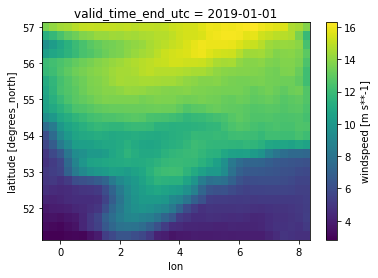

In [14]:
north_sea_wind_sample.sel({"valid_time_end_utc": "2019-01-01T00:00:00.000000000"}).plot.imshow()
plt.show()

In [15]:
north_sea_wind_time_series = north_sea_wind_sample.mean(dim=["lat", "lon"])
north_sea_wind_time_series.hvplot()

:Curve   [valid_time_end_utc]   (windspeed)

In [16]:
north_sea_wind_time_series.resample(valid_time_end_utc="1d").mean().hvplot()

:Curve   [valid_time_end_utc]   (windspeed)

In [25]:
north_sea_wind_time_series.resample(valid_time_end_utc="1Y").mean().hvplot()

:Curve   [valid_time_end_utc]   (windspeed)

In [42]:
lon_min, lat_min, lon_max, lat_max = 5.150391, 53.766854, 8.270508, 55.867472
de_dk_nl_sample = era5_europe["windspeed"].sel({"lat": slice(lat_max, lat_min), "lon": slice(lon_min, lon_max)})
de_dk_nl_sample

<xarray.DataArray 'windspeed' (valid_time_end_utc: 96432, lat: 8, lon: 13)>
dask.array<getitem, shape=(96432, 8, 13), dtype=float32, chunksize=(720, 7, 11), chunktype=numpy.ndarray>
Coordinates:
  * lat                 (lat) float32 55.75 55.5 55.25 55.0 ... 54.5 54.25 54.0
  * lon                 (lon) float32 5.25 5.5 5.75 6.0 ... 7.5 7.75 8.0 8.25
  * valid_time_end_utc  (valid_time_end_utc) datetime64[ns] 2011-01-01 ... 20...
Attributes:
    units:    m s**-1

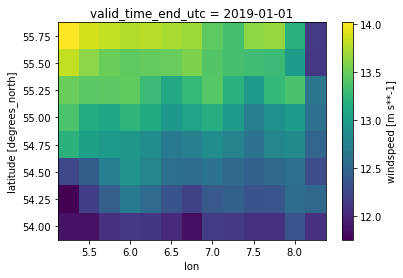

In [43]:
de_dk_nl_sample.sel({"valid_time_end_utc": "2019-01-01T00:00:00.000000000"}).plot.imshow()
plt.show()

In [44]:
de_dk_nl_sample_time_series = de_dk_nl_sample.mean(dim=["lat", "lon"])
de_dk_nl_sample_time_series.hvplot()

:Curve   [valid_time_end_utc]   (windspeed)

In [45]:
de_dk_nl_sample_time_series.resample(valid_time_end_utc="1d").mean().hvplot()

:Curve   [valid_time_end_utc]   (windspeed)

In [46]:
de_dk_nl_sample_time_series.resample(valid_time_end_utc="1d").mean().rolling(valid_time_end_utc=7, center=True).mean().hvplot()

:Curve   [valid_time_end_utc]   (windspeed)

In [47]:
de_dk_nl_sample_time_series.resample(valid_time_end_utc="1Y").mean().hvplot()

:Curve   [valid_time_end_utc]   (windspeed)

In [48]:
de_dk_nl_sample_series = de_dk_nl_sample_time_series.to_pandas()
north_sea_sample_series= north_sea_wind_time_series.to_pandas()
sample_df = pd.DataFrame({"north_sea_sample": north_sea_sample_series, "de_dk_nl_coast_sample": de_dk_nl_sample_series})
sample_df.head()

north_sea_sample  de_dk_nl_coast_sample
valid_time_end_utc                                          
2011-01-01 00:00:00          9.214479              13.239870
2011-01-01 01:00:00          9.353499              13.169409
2011-01-01 02:00:00          9.448727              13.206489
2011-01-01 03:00:00          9.440489              12.920491
2011-01-01 04:00:00          9.429975              12.621303

In [24]:
sample_df.to_csv("../data/era_timeseries/offshore_wind_sample.csv", index=True, index_label="DateTime")

In [78]:
wind_zones = gpd.read_file("../data/gis/wind_zones.shp")
wind_zones

id                     desc  \
0    1            north germany   
1    2              north spain   
2    3               east spain   
3    4        north west france   
4    5      north france amiens   
5    6   france seine champagne   
6    7         north uk onshore   
7    8         east uk offshore   
8    9         west uk offshore   
9    9   north sea west denmark   
10  10  north sea north germany   
11  11             east austria   
12  12       south italy napoli   
13  13      republic of ireland   

                                             geometry  
0   POLYGON ((8.64256 54.85282, 8.66131 54.84742, ...  
1   POLYGON ((-8.94268 43.57422, -1.75852 43.27451...  
2   POLYGON ((0.89099 41.24446, -0.27198 39.87649,...  
3   POLYGON ((-3.73276 48.68731, -3.56863 48.66254...  
4   POLYGON ((1.60846 50.55683, 4.07040 50.24897, ...  
5   POLYGON ((3.46077 49.04284, 4.68940 49.02131, ...  
6   POLYGON ((-3.31243 56.16904, -3.28264 56.16351...  
7   POLYGON ((0.37054 53.35832, 0.42386 53.34771, ...  
8   POLYGON ((-3.47614 54.27591, -3.24483 54.03209...  
9   POLYGON ((8.04908 57.00924, 7.78942 55.62013, ...  
10  POLYGON ((5.08130 54.43155, 7.50564 54.98733, ...  
11  POLYGON ((16.02406 48.76052, 16.90898 48.65435...  
12  POLYGON ((14.64123 42.11854, 16.63759 41.13520...  
13  POLYGON ((-8.16298 54.38448, -6.34227 53.89490...

In [79]:
weightmap_complete = xa.pixel_overlaps(era5_europe, wind_zones)
aggregated_complete = xa.aggregate(era5_europe, weightmap_complete)

creating polygons for each pixel...
lat/lon bounds not found in dataset; they will be created.


/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


calculating overlaps between pixels and output polygons...
success!


/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


adjusting grid... (this may happen because only a subset of pixels were used for aggregation for efficiency - i.e. [subset_bbox=True] in xa.pixel_overlaps())
grid adjustment successful
aggregating air_temperature_at_2_metres...
aggregating windspeed...
all variables aggregated to polygons!


In [91]:
wind_zones_aggregated = aggregated_complete.to_dataset()
wind_zones_aggregated = wind_zones_aggregated.assign_coords({"poly_idx": wind_zones["desc"].values})
wind_zones_aggregated

<xarray.Dataset>
Dimensions:                      (poly_idx: 14, valid_time_end_utc: 96432)
Coordinates:
  * poly_idx                     (poly_idx) object 'north germany' ... 'repub...
  * valid_time_end_utc           (valid_time_end_utc) datetime64[ns] 2011-01-...
Data variables:
    id                           (poly_idx) int64 1 2 3 4 5 6 ... 9 10 11 12 13
    desc                         (poly_idx) object 'north germany' ... 'repub...
    air_temperature_at_2_metres  (poly_idx, valid_time_end_utc) float64 1.396...
    windspeed                    (poly_idx, valid_time_end_utc) float64 6.856...

In [92]:
wind_zones_aggregated["windspeed"].resample(
    valid_time_end_utc="1d"
).mean().rolling(valid_time_end_utc=7, center=True).mean().hvplot.line(
    x="valid_time_end_utc", y="windspeed"
)

:DynamicMap   [poly_idx]
   :Curve   [valid_time_end_utc]   (windspeed)

In [93]:
wind_zones_aggregated["air_temperature_at_2_metres"].resample(
    valid_time_end_utc="1d"
).mean().rolling(valid_time_end_utc=7, center=True).mean().hvplot.line(x="valid_time_end_utc", y="air_temperature_at_2_metres")

:DynamicMap   [poly_idx]
   :Curve   [valid_time_end_utc]   (air_temperature_at_2_metres)

In [100]:
aggregated_complete.to_csv("../data/era_timeseries/wind_zones_time_series.csv")

../data/era_timeseries/wind_zones_time_series.csv saved!


In [101]:
aggregated_reloaded = pd.read_csv("../data/era_timeseries/wind_zones_time_series.csv")
aggregated_reloaded = aggregated_reloaded.drop(columns=["poly_idx", "id"])
aggregated_reloaded.to_csv("../data/era_timeseries/wind_zones_time_series.csv", index=False)

In [96]:
client.close()
cluster.close()